In [1]:
from alpha_vantage.cryptocurrencies import CryptoCurrencies
import pandas_ta as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import os

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

key = os.environ['av_key']

In [2]:
cc = CryptoCurrencies(key=key, output_format='pandas')

In [3]:
df, meta_data = cc.get_crypto_intraday('ETH', market='USD', interval='1min', outputsize='full')

In [4]:
df = df.rename(columns={"4. close": "close",
                   "1. open": "open",
                   "2. high": "high",
                   "3. low": "low",
                   "5. volume": "volume"})

df = df[['open', 'high', 'low', 'close', 'volume']]

In [5]:
df = df.sort_index()
df['idx_int'] = np.arange(0, len(df))
df = df.reset_index()

In [6]:
df.head()

,date,open,high,low,close,volume,idx_int
0,2024-11-15 11:52:00,3099.15,3100.43,3098.18,3098.98,21.0,0
1,2024-11-15 11:53:00,3099.44,3102.60,3099.29,3102.02,21.0,1
2,2024-11-15 11:54:00,3102.11,3102.59,3099.92,3100.13,67.0,2
3,2024-11-15 11:55:00,3100.11,3102.68,3099.93,3101.97,25.0,3
4,2024-11-15 11:56:00,3102.48,3103.83,3101.46,3102.69,14.0,4


In [7]:
def compute_gradient(start_index, df, x_label, y_label, len_data):
    # Ensure we only take data points from n to n+5
    if start_index + len_data > len(df):
        return None  # Return None if there are not enough points to calculate gradient
    
    # Extract the last 5 data points (x, y) from the DataFrame
    data_segment = df.iloc[start_index:start_index + len_data]
    x = data_segment[x_label]
    y = data_segment[y_label]
    
    # Calculate the necessary summations for the least squares formula
    n = len(x)
    sum_x = x.sum()
    sum_y = y.sum()
    sum_x2 = (x**2).sum()
    sum_xy = (x * y).sum()
    
    # Calculate the slope (gradient) using the least squares formula
    slope = (n * sum_xy - sum_x * sum_y) / (n * sum_x2 - sum_x**2)
    return slope

def check_crossing(df, col1, col2):
    # Calculate the difference between the two columns
    diff = df[col1] - df[col2]
    diff = diff/np.abs(diff)
    # Check if there is a sign change in the difference
    crossing = ((diff.shift(1) * diff) - 1)/-2
    
    return crossing

def compute_gradient_normalize(start_index, df, x_label, y_label, len_data):
    # Ensure we only take data points from n to n+5
    if start_index + len_data > len(df):
        return None  # Return None if there are not enough points to calculate gradient

    # Extract the last 5 data points (x, y) from the DataFrame
    data_segment = df.iloc[start_index:start_index + len_data]
    x = data_segment[x_label]
    y = data_segment[y_label]

    #normalize y
    min_y = np.min(y)
    max_y = np.max(y)
    y = (y-min_y)/(max_y - min_y)

    # Calculate the necessary summations for the least squares formula
    n = len(x)
    sum_x = x.sum()
    sum_y = y.sum()
    sum_x2 = (x ** 2).sum()
    sum_xy = (x * y).sum()

    # Calculate the slope (gradient) using the least squares formula
    slope = (n * sum_xy - sum_x * sum_y) / (n * sum_x2 - sum_x ** 2)
    return slope

In [8]:
# realtime stock trading
df.ta.ema(length=10, append=True)
df.ta.ema(length=50, append=True)
df.ta.rsi(length=14, append=True)
df.ta.bbands(length=20, std=2, append=True)
df.ta.macd(fast=12, slow=26, signal=9, append=True)
df.ta.psar(append=True)
df.ta.adx(append=True)

,ADX_14,DMP_14,DMN_14
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
345,20.679310,14.594734,29.854526
346,21.654417,13.952673,28.541146
347,22.188805,14.969974,27.279808
348,22.587286,14.795157,26.170238


In [9]:
try: df = df.rename(columns={'EMA_60':'EMA_50'})
except: print("skip")

In [10]:
df['psar_flip_dir'] = 0
df.loc[(df['PSARr_0.02_0.2']==1) & (df['PSARl_0.02_0.2'].isnull()==False), 'psar_flip_dir'] = 1
df.loc[(df['PSARr_0.02_0.2']==1) & (df['PSARs_0.02_0.2'].isnull()==False), 'psar_flip_dir'] = -1

In [11]:
df.head()

,date,open,high,low,close,volume,idx_int,EMA_10,EMA_50,RSI_14,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,PSARl_0.02_0.2,PSARs_0.02_0.2,PSARaf_0.02_0.2,PSARr_0.02_0.2,ADX_14,DMP_14,DMN_14,psar_flip_dir
0,2024-11-15 11:52:00,3099.15,3100.43,3098.18,3098.98,21.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,0,NaN,NaN,NaN,0
1,2024-11-15 11:53:00,3099.44,3102.60,3099.29,3102.02,21.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3036.010000,NaN,0.04,0,NaN,NaN,NaN,0
2,2024-11-15 11:54:00,3102.11,3102.59,3099.92,3100.13,67.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3038.673600,NaN,0.04,0,NaN,NaN,NaN,0
3,2024-11-15 11:55:00,3100.11,3102.68,3099.93,3101.97,25.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3041.230656,NaN,0.06,0,NaN,NaN,NaN,0
4,2024-11-15 11:56:00,3102.48,3103.83,3101.46,3102.69,14.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3044.917617,NaN,0.08,0,NaN,NaN,NaN,0


In [12]:
df['r_ema_s_m'] = df['EMA_10'] / df['EMA_50']

In [13]:
len_data = 3
len_data_norm = 15

# Loop through the DataFrame, compute gradient for each row (starting point)
for i in range(len(df) - len_data):  # Make sure we have at least 5 points for each calculation
    gradient = compute_gradient(i, df, 'idx_int', 'EMA_10', len_data)
    df.at[i + len_data, 'gradient_ema_10'] = gradient  # Store the gradient in the row corresponding to n+4
    gradient = compute_gradient(i, df, 'idx_int', 'RSI_14', len_data)
    df.at[i + len_data, 'gradient_rsi_14'] = gradient  # Store the gradient in the row corresponding to n+4
    gradient = compute_gradient(i, df, 'idx_int', 'close', len_data)
    df.at[i + len_data, 'gradient_ls'] = gradient
    gradient = compute_gradient(i, df, 'idx_int', 'EMA_50', len_data)
    df.at[i + len_data, 'gradient_ema_50'] = gradient  # Store the gradient in the row corresponding to n+4

for i in range(len(df) - len_data_norm):  # Make sure we have at least 5 points for each calculation
    gradient = compute_gradient_normalize(i, df, 'idx_int', 'EMA_10', len_data_norm)
    df.at[i + len_data_norm, 'gradient_ema_10_norm'] = gradient  # Store the gradient in the row corresponding to n+4

In [14]:
# mask_crossing = (df['r_ema_s_m']<1.0005)&(df['r_ema_s_m']>0.9995)
# df['flag_ema_crossing'] = 0
# df.loc[mask_crossing, 'flag_ema_crossing'] = 1

In [15]:
df['flag_ema_crossing'] = check_crossing(df, 'EMA_10', 'EMA_50')

In [16]:
df.iloc[-30:]

,date,open,high,low,close,volume,idx_int,EMA_10,EMA_50,RSI_14,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,PSARl_0.02_0.2,PSARs_0.02_0.2,PSARaf_0.02_0.2,PSARr_0.02_0.2,ADX_14,DMP_14,DMN_14,psar_flip_dir,r_ema_s_m,gradient_ema_10,gradient_rsi_14,gradient_ls,gradient_ema_50,gradient_ema_10_norm,flag_ema_crossing
320,2024-11-15 17:27:00,3042.48,3042.76,3038.52,3041.96,345.0,320,3046.137157,3041.470446,45.305079,3039.337384,3046.8750,3054.412616,0.494777,0.173969,1.663942,-1.357315,3.021257,NaN,3054.516789,0.08,0,23.757932,18.881625,24.987111,0,1.001534,-0.830349,-2.529880,-1.495,0.100210,0.068910,-0.0
321,2024-11-15 17:28:00,3041.96,3042.40,3039.15,3039.15,186.0,321,3044.866765,3041.379448,40.933415,3038.219444,3046.4695,3054.719556,0.541614,0.056397,0.973885,-1.637897,2.611783,NaN,3053.237046,0.08,0,23.055053,17.823334,23.586616,0,1.001147,-1.030286,-3.281195,-1.930,0.020594,0.053791,-0.0
322,2024-11-15 17:29:00,3039.16,3041.54,3037.65,3041.02,229.0,322,3044.167353,3041.365352,44.753925,3037.696873,3046.2670,3054.837127,0.562664,0.193879,0.571318,-1.632372,2.203690,NaN,3052.059682,0.10,0,22.789961,16.622424,24.595529,0,1.000921,-1.099325,-2.193829,-1.410,-0.035508,0.032894,-0.0
323,2024-11-15 17:30:00,3041.13,3043.72,3039.34,3043.53,225.0,323,3044.051471,3041.450240,49.477602,3037.774893,3046.2990,3054.823107,0.559637,0.337578,0.449634,-1.403245,1.852878,NaN,3050.618714,0.10,0,21.778320,19.126211,22.737811,0,1.000855,-0.984902,-0.275577,-0.470,-0.052547,0.007808,-0.0
324,2024-11-15 17:31:00,3043.70,3043.71,3037.56,3038.60,166.0,324,3043.060294,3041.338466,41.899721,3037.333543,3046.1890,3055.044457,0.581412,0.071507,-0.044104,-1.517586,1.473482,NaN,3049.321843,0.12,0,21.316575,17.165694,23.373878,0,1.000566,-0.407647,4.272093,2.190,0.035396,-0.019849,-0.0
325,2024-11-15 17:32:00,3038.49,3038.49,3031.52,3036.59,190.0,325,3041.883877,3041.152251,39.259629,3036.038933,3045.8095,3055.580067,0.641574,0.028200,-0.590774,-1.651405,1.060631,NaN,3047.910422,0.14,0,22.164160,15.230207,30.357457,0,1.000241,-0.553529,-1.427102,-1.210,-0.013443,-0.041314,-0.0
326,2024-11-15 17:33:00,3036.01,3040.08,3032.12,3038.51,415.0,326,3041.270445,3041.048634,42.957057,3035.316314,3045.5565,3055.796686,0.672467,0.155939,-0.859182,-1.535850,0.676668,NaN,3045.615763,0.14,0,22.414272,15.800138,26.710908,0,1.000073,-1.083797,-5.108987,-3.470,-0.148994,-0.055317,-0.0
327,2024-11-15 17:34:00,3038.50,3040.22,3036.40,3038.93,116.0,327,3040.844909,3040.965550,43.763500,3034.630757,3045.2685,3055.906243,0.698641,0.202075,-1.026178,-1.362277,0.336099,NaN,3043.642356,0.14,0,22.598735,15.090819,25.149620,0,0.999960,-0.894925,0.528668,-0.045,-0.144916,-0.067250,1.0
328,2024-11-15 17:35:00,3038.93,3041.29,3037.62,3038.45,124.0,328,3040.409471,3040.866901,43.015040,3033.832680,3044.8010,3055.769320,0.720462,0.210484,-1.183611,-1.215768,0.032157,NaN,3041.945226,0.14,0,22.395236,15.892875,23.715411,0,0.999850,-0.519484,2.251935,1.170,-0.093351,-0.075722,-0.0
329,2024-11-15 17:36:00,3038.85,3039.18,3035.08,3037.16,86.0,329,3039.818658,3040.721532,40.986292,3032.911787,3044.2590,3055.606213,0.745483,0.187192,-1.396374,-1.142825,-0.253549,NaN,3041.290000,0.14,0,22.761787,14.872484,26.170317,0,0.999703,-0.430487,0.028991,-0.030,-0.090866,-0.079285,-0.0


In [17]:
mask_ema_grad_pos = (df['gradient_ema_10']>0.05)
mask_ema_grad_neg = (df['gradient_ema_10']<-0.05)
df['flag_grad_ema'] = 0
df.loc[mask_ema_grad_pos, 'flag_grad_ema'] = 1
df.loc[mask_ema_grad_neg, 'flag_grad_ema'] = -1

mask_ema_grad_pos = (df['gradient_ema_50']>0.05)
mask_ema_grad_neg = (df['gradient_ema_50']<-0.05)
df['flag_grad_ema_50'] = 0
df.loc[mask_ema_grad_pos, 'flag_grad_ema_50'] = 1
df.loc[mask_ema_grad_neg, 'flag_grad_ema_50'] = -1

mask_rsi_grad_pos = (df['gradient_rsi_14']>=1)
mask_rsi_grad_neg = (df['gradient_rsi_14']<=1)
df['flag_grad_rsi'] = 0
df.loc[mask_rsi_grad_pos, 'flag_grad_rsi'] = 1
df.loc[mask_rsi_grad_neg, 'flag_grad_rsi'] = -1

df['flag_grad_ls'] = 0
df.loc[df['gradient_ls'] >= 0.05, 'flag_grad_ls'] = 1
df.loc[df['gradient_ls'] <= -0.05, 'flag_grad_ls'] = -1

In [18]:
df['ema_short_above_or_below'] = 0
df.loc[(df['EMA_10']>df['EMA_50']), 'ema_short_above_or_below'] = 1
df.loc[(df['EMA_10']<df['EMA_50']), 'ema_short_above_or_below'] = -1

In [19]:
df['r_close_bbu'] = df['close'] / df['BBU_20_2.0']
df['r_close_bbl'] = df['close'] / df['BBL_20_2.0']
df['r_ema_bbu'] = df['EMA_10'] / df['BBU_20_2.0']
df['r_ema_bbl'] = df['EMA_10'] / df['BBL_20_2.0']

# Strategy

To create a real-time trading strategy with specific technical indicator settings and strategies for entering and exiting trades, let's break down the components clearly:

### 1. **Technical Indicators**
Here's how we can set up the specific technical indicators:

#### Moving Averages
- **Short-Term Moving Average (MA)**: Use a 10-period MA. This is effective for spotting short-term trends and suitable for minute-by-minute trading data.
- **Long-Term Moving Average**: Use a 50-period MA to confirm the overall trend direction. This helps filter out the noise and provides a clearer direction.

#### Relative Strength Index (RSI)
- **Length**: A 14-period RSI is standard and works well in a variety of market conditions.
- **Overbought Threshold**: Set at 70 to indicate potential selling points.
- **Oversold Threshold**: Set at 30 to indicate potential buying points.

#### MACD (Moving Average Convergence Divergence)
- **Fast Line**: 12-period Exponential Moving Average (EMA)
- **Slow Line**: 26-period EMA
- **Signal Line**: 9-period EMA of the MACD line itself

### 2. **Entry and Exit Points**
- **Go Long (Buy)**: 
  - **Entry Point**: When the 10-period MA crosses above the 50-period MA and the RSI is below 70 but above 30, indicating neither overbought nor oversold conditions. Additionally, the MACD line should cross above the signal line.
  - **Exit Point (Take Profit)**: Consider exiting when the 10-period MA crosses back below the 50-period MA, or RSI approaches 70, indicating a potential overbought condition.
  
- **Go Short (Sell)**: 
  - **Entry Point**: When the 10-period MA crosses below the 50-period MA and the RSI is above 30 but below 70, indicating normal conditions. Also, the MACD line should cross below the signal line.
  - **Exit Point (Take Profit)**: Consider exiting when the 10-period MA crosses back above the 50-period MA, or RSI approaches 30, indicating a potential oversold condition.

### 3. **Stop Loss Criteria**
- **For Long Positions**: Place a stop loss below the most recent significant low or a fixed percentage, such as 2-3% below the entry price, depending on your risk tolerance.
- **For Short Positions**: Place a stop loss above the most recent significant high or a fixed percentage, such as 2-3% above the entry price.

### 4. **Risk Management**
- Consider the amount of capital at risk per trade, commonly 1-2% of your total trading capital to manage risk effectively.
- Use trailing stops to lock in profits as the market moves in your favor.

### 5. **Automation and Monitoring**
- Automate the strategy using a trading bot if possible, especially to handle the high-frequency nature of minute-by-minute trading.
- Regularly monitor performance and adjust parameters as necessary based on market conditions and strategy performance.

This setup gives you a robust framework for trading on a minute-by-minute basis, leveraging these technical indicators to make informed trading decisions. Adjust these settings based on backtesting results and your specific risk tolerance.

# Buy Signal

In [20]:
mask_le1 = (df['ema_short_above_or_below']==1)&(df['flag_ema_crossing']==1)
mask_le2 = (df['MACDh_12_26_9']>0)
mask_le3 = (df['r_close_bbl']<=1.0005)
mask_le4 = (df['RSI_14']<70)&(df['RSI_14']>30)
mask_le5 = (df['PSARl_0.02_0.2'] < df['close']) & (df['psar_flip_dir']>0)
mask_le6 = (df['RSI_14']<40)
mask_le7 = (df['flag_grad_ema']>=0)

df['ema_crossing_pos'] = 0
df.loc[mask_le1, 'ema_crossing_pos'] = 1
df['macd_pos'] = 0
df.loc[mask_le2, 'macd_pos'] = 1
df['close_to_bbl'] = 0
df.loc[mask_le3, 'close_to_bbl'] = 1
df['rsi_30_to_70'] = 0
df.loc[mask_le4, 'rsi_30_to_70'] = 1
df['PSAR_bellow_close'] = 0
df.loc[mask_le5, 'PSAR_bellow_close'] = 1

df['buy_signal'] = np.nan
# df.loc[(mask_le1 & mask_le4) | (mask_le5 & mask_le4 & mask_le2) | (mask_le2 & mask_le6 & mask_le3), 'long_entry'] = 1
# df.loc[(mask_le1 & mask_le4) | (mask_le6 & mask_le7), 'buy_signal'] = 1
df.loc[(mask_le1 & mask_le4) | (mask_le3 & mask_le7), 'buy_signal'] = 1

# Sell signal

In [21]:
mask_lex1 = (df['ema_short_above_or_below']==-1)&(df['flag_ema_crossing']==1)
# mask_lex2 = (df['RSI_14']>70)
mask_lex2 = (df['RSI_14']>55)
mask_lex3 = (df['psar_flip_dir'] == -1)
mask_lex4 = (df['flag_grad_ema']==0)
mask_lex5 = (df['MACDh_12_26_9']<0)
mask_lex6 = (df['r_close_bbu']>0.9995)

df['ema_crossing_neg'] = 0
df.loc[mask_lex1, 'ema_crossing_neg'] = 1
df['rsi_above_70'] = 0
df.loc[mask_lex2, 'rsi_above_70'] = 1
df['psar_flip_neg'] = 0
df.loc[mask_lex3, 'psar_flip_neg'] = 1
df['macd_neg'] = 0
df.loc[mask_lex5, 'macd_neg'] = 1

df['sell_signal'] = np.nan
df.loc[(mask_lex1) | (mask_lex2 & mask_lex4), 'sell_signal'] = 1

# Bullish / bearish confirmation

In [22]:
mask_bulber = (df['ADX_14']>=25)
mask_bul = (df['DMP_14']>=25)
mask_ber = (df['DMN_14']>=25)

df['trend_confirm'] = 0
df.loc[mask_bulber & mask_bul, 'trend_confirm'] = 1
df.loc[mask_bulber & mask_ber, 'trend_confirm'] = -1

# Over-sold/buy Marker

In [23]:
mask_os1 = (df['RSI_14']<=20)
mask_os2 = (df['r_close_bbl']<=1.000)
mask_ob1 = (df['RSI_14']>=80)
mask_ob2 = (df['r_close_bbu']>=1.000)

In [24]:
df['oversold_confirm'] = 0
df.loc[mask_os1|mask_os2, 'oversold_confirm'] = 1
df.loc[mask_ob1|mask_ob2, 'oversold_confirm'] = -1

# Check data

In [25]:
df.to_clipboard()

In [26]:
series_crypto = df.iloc[-1:][['oversold_confirm', 'trend_confirm', 'sell_signal', 'buy_signal']].sum()

In [27]:
string_f = f"Etherium: \n\n{series_crypto}"

print(string_f)

Etherium: 

oversold_confirm    0.0
trend_confirm       0.0
sell_signal         0.0
buy_signal          0.0
dtype: float64


## Picture

In [28]:
df.head()

,date,open,high,low,close,volume,idx_int,EMA_10,EMA_50,RSI_14,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,PSARl_0.02_0.2,PSARs_0.02_0.2,PSARaf_0.02_0.2,PSARr_0.02_0.2,ADX_14,DMP_14,DMN_14,psar_flip_dir,r_ema_s_m,gradient_ema_10,gradient_rsi_14,gradient_ls,gradient_ema_50,gradient_ema_10_norm,flag_ema_crossing,flag_grad_ema,flag_grad_ema_50,flag_grad_rsi,flag_grad_ls,ema_short_above_or_below,r_close_bbu,r_close_bbl,r_ema_bbu,r_ema_bbl,ema_crossing_pos,macd_pos,close_to_bbl,rsi_30_to_70,PSAR_bellow_close,buy_signal,ema_crossing_neg,rsi_above_70,psar_flip_neg,macd_neg,sell_signal,trend_confirm,oversold_confirm
0,2024-11-15 11:52:00,3099.15,3100.43,3098.18,3098.98,21.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN,0,0,0,0,NaN,0,0
1,2024-11-15 11:53:00,3099.44,3102.60,3099.29,3102.02,21.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3036.010000,NaN,0.04,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN,0,0,0,0,NaN,0,0
2,2024-11-15 11:54:00,3102.11,3102.59,3099.92,3100.13,67.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3038.673600,NaN,0.04,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN,0,0,0,0,NaN,0,0
3,2024-11-15 11:55:00,3100.11,3102.68,3099.93,3101.97,25.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3041.230656,NaN,0.06,0,NaN,NaN,NaN,0,NaN,0.0,0.0,0.575,0.0,NaN,NaN,0,0,-1,1,0,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN,0,0,0,0,NaN,0,0
4,2024-11-15 11:56:00,3102.48,3103.83,3101.46,3102.69,14.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3044.917617,NaN,0.08,0,NaN,NaN,NaN,0,NaN,0.0,0.0,-0.025,0.0,NaN,NaN,0,0,-1,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN,0,0,0,0,NaN,0,0


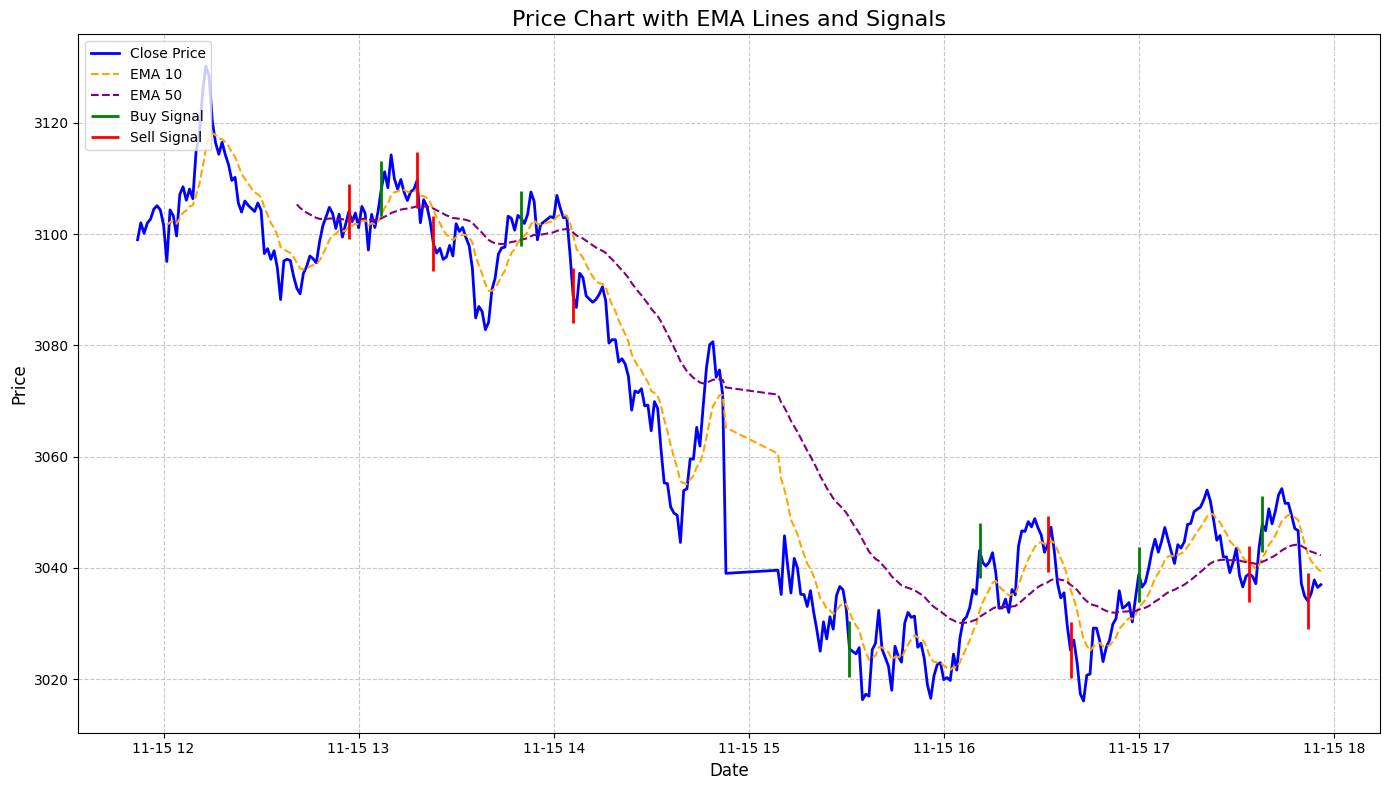

In [29]:
# Set up the plot
plt.figure(figsize=(14, 8))

# Plot the main line chart for 'close'
plt.plot(df['date'], df['close'], label='Close Price', color='blue', linewidth=2)

# Plot the EMA_10 line
plt.plot(df['date'], df['EMA_10'], label='EMA 10', color='orange', linestyle='--', linewidth=1.5)

# Plot the EMA_50 line
plt.plot(df['date'], df['EMA_50'], label='EMA 50', color='purple', linestyle='--', linewidth=1.5)

# Add buy signal bars
buy_signals = df[df['buy_signal'] == 1]
plt.vlines(buy_signals['date'], buy_signals['close'] - 5, buy_signals['close'] + 5, color='green', label='Buy Signal', linewidth=2)

# Add sell signal bars
sell_signals = df[df['sell_signal'] == 1]
plt.vlines(sell_signals['date'], sell_signals['close'] - 5, sell_signals['close'] + 5, color='red', label='Sell Signal', linewidth=2)

# Formatting the chart
plt.title('Price Chart with EMA Lines and Signals', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()